# Checking evaluation results

This notebook is used to check the evaluation results of the parenting chatbot prototype.

The evaluation results have been downloaded from an EC2 instance and stored on S3. 

We do a few simple checks:
- Which source of answers (human, rag, gpt4) have been preffered by the annotaters the most? 
- Are there any patterns when it comes to specific questions?


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dotenv
from os import environ
import re
from typing import Dict, List

from genai.utils import read_jsonl_from_s3

dotenv.load_dotenv()

# S3 path to evaluation data
PATH = f"s3://{environ.get('S3_BUCKET')}/prototypes/parenting-chatbot/prodigy_evaluation/"
# Titles of the three options
OPTIONS = ["Human", "Chatbot", "GPT-4"]


def extract_question(text:str) -> str:
    """Extract the question from the text, 
    which is always between > and < symbols
    """
    return re.search(r">(.*)<", text).group(1)


def extract_options(options: Dict) -> List:
    """Extract options (ie, human, rag or gpt4) from the dictionary
    """
    return [option['id'] for option in options]


def total_number_of_evaluations(eval_data: List, accepted_sessions: List) -> int:
    """Return the total number of evaluations

    eval_data (List): Evaluation data from Prodigy
    accepted_sessions (List): Sessions to use for final results
    """
    return len(
        pd.DataFrame(data=eval_data)
        .query("_session_id in @accepted_sessions")
    )


def prepare_evaluation_dataframe(eval_data: List, accepted_sessions: List) -> pd.DataFrame:
    """Prepare the evaluation dataframe

    Args:
        eval_data (List): Evaluation data from Prodigy
        accepted_sessions (List): Sessions to use for final results
    """
    return (
        pd.DataFrame(data=eval_data)
        .query("_session_id in @accepted_sessions")
        # Only use tests where one of the answers was picked
        .query("answer == 'accept'")
        # Preprocessing the data
        .assign(
            question=lambda df: df["html"].apply(extract_question),
            option_1=lambda df: df["options"].apply(lambda x: extract_options(x)[0]),
            option_2=lambda df: df["options"].apply(lambda x: extract_options(x)[1]),
            no_of_accept=lambda df: df["accept"].apply(len),
        )
        .query("no_of_accept == 1")
        .assign(accept=lambda df: df["accept"].apply(lambda x: x[0]))
        .replace({"rag": "Chatbot", "gpt4": "GPT-4", "human": "Human"})
    )[["question", "option_1", "option_2", "accept"]]


def get_win_matrix(
        eval_df: pd.DataFrame, 
        options: List, 
        normalised: bool=True
    ) -> pd.DataFrame:
    """Create a matrix showing the number or percentage of wins for each option
    Rows are the winner, columns are the loser

    Args:
        eval_df (pd.DataFrame): Dataframe with evaluation data, with column: question, option_1, option_2, accept, _session_id
        options (List): The options to include in the matrix
        normalised (bool, optional): Whether to normalise the matrix to percentages. Defaults to True.

    Returns:
        pd.DataFrame: Matrix with number or percentage of wins for each option
    """

    # Initialize an empty matrix for pairwise comparisons
    matrix = pd.DataFrame(np.zeros((3, 3)), index=options, columns=options)

    # Populate the matrix based on the dataframe
    for _, row in eval_df.iterrows():
        winner = row['accept']
        loser = row['option_1'] if (row['option_2'] == winner) else row['option_2']
        matrix.at[winner, loser] += 1

    # Normalise the matrix
    if normalised:
        normalized_matrix = matrix.copy()
        for i in options:
            for j in options:
                total = matrix.at[i, j] + matrix.at[j, i]
                if total != 0:
                    normalized_matrix.at[i, j] = (matrix.at[i, j] / total) * 100        
        matrix = normalized_matrix
    
    # Replace diagonal with null values
    matrix = matrix.mask(np.eye(len(matrix), dtype=bool))
    return matrix


def get_question_matrix(
        eval_df: pd.DataFrame, 
        options: List, 
        normalised: bool=True
    ) -> pd.DataFrame:
    # Create a matrix with questions as rows and options as columns
    question_matrix = pd.DataFrame(index=eval_df['question'].unique(), columns=options, data=0)

    # Populate the matrix based on the dataframe
    for _, row in eval_df.iterrows():
        chosen_option = row['accept']
        question_matrix.at[row['question'], chosen_option] += 1

    # Normalize the counts to percentages
    if normalised:
        question_matrix = (question_matrix.T / question_matrix.sum(axis=1)).T * 100

    return question_matrix


def plot_heatmap(matrix: pd.DataFrame, square: bool = True, percentages: bool=True, savepath: str = None):
    """Plot a heatmap of the wins matrix

    Args:
        matrix (_type_): A matrix with the number or percentage of wins for each option
        square (bool, optional): Whether the aspect ratio should be square. Defaults to True.
        percentages (bool, optional): Whether the values in the matrix should be percentages. Defaults to True.
        savepath (str, optional): Path to save the figure. Defaults to None.
    
    Returns:
        None
    """
    ax = sns.heatmap(
        matrix, 
        annot=True, 
        cmap=sns.color_palette("light:b", as_cmap=True), 
        fmt=".0f",
        vmax=100,
        cbar=False,
        xticklabels=True,
        yticklabels=True,
        square=square,
        linewidths=0.5,
    )
    # Move x-axis labels to top
    ax.xaxis.tick_top()
    # Rotate x-axis labels
    plt.yticks(rotation=0)
    # Remove axis ticks
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, left=False)
    # Add percentage sign to annotations
    if percentages:
        for t in ax.texts: t.set_text(t.get_text() + "%")
    # Save figure
    if savepath is not None:
        ax.figure.savefig(savepath, dpi=300, bbox_inches="tight")



## Load and process data

In [9]:
# Evaluation data from Prodigy
eval_data = read_jsonl_from_s3(PATH + "output_20231010.jsonl")

eval_data[0]

{'html': "Which one is a better answer to this question:\n\n<span style='font-weight: bold; font-size:30px'>How to get baby to sleep?</span>",
 'options': [{'id': 'human',
   'html': 'Babies can vary in their sleep patterns, especially in the first few months of life. Tips to get your baby to sleep involve encouraging a routine or sleep habits, including a bath, cuddling, singing and quiet music in a dimly lit room. Give your baby time to settle down after comforting, we also recommend putting them down drowsy but still awake, with a comforter such as a teddy bear or a pacifier, allowing them to be soothed to sleep.'},
  {'id': 'gpt4',
   'html': "Establishing a consistent bedtime routine can help your baby understand that it's time to sleep. This can include activities like a warm bath, a bedtime story, or a lullaby. Try to make the environment conducive to sleep by keeping the room dark and at a comfortable temperature. Some babies might also find white noise or a pacifier soothing. 

In [10]:
# Sessions to use for final results
accepted_sessions = read_jsonl_from_s3(PATH + "accepted_sessions.jsonl")[0]['sessions']

print(f"Total number of evaluations: {total_number_of_evaluations(eval_data, accepted_sessions)}")

eval_df = prepare_evaluation_dataframe(eval_data, accepted_sessions)
eval_df.head(5)

Total number of evaluations: 96


,question,option_1,option_2,accept
11,How to change a nappy?,Human,GPT-4,GPT-4
12,How to store breast milk?,Human,Chatbot,Chatbot
13,How to store breast milk?,Human,GPT-4,GPT-4
14,When to stop breastfeeding?,Chatbot,GPT-4,Chatbot
15,How to get baby to sleep?,Chatbot,GPT-4,Chatbot


## Pairwise comparisons between different types of answers

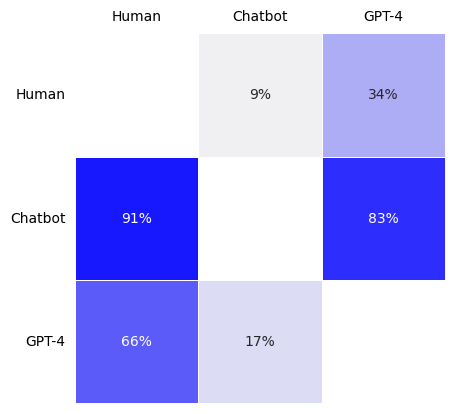

In [11]:
matrix = get_win_matrix(eval_df, OPTIONS, normalised=True)
plot_heatmap(matrix, savepath="charts/win_matrix.png", percentages=True, square=True)

## Percentage of wins by type of answer, per each question

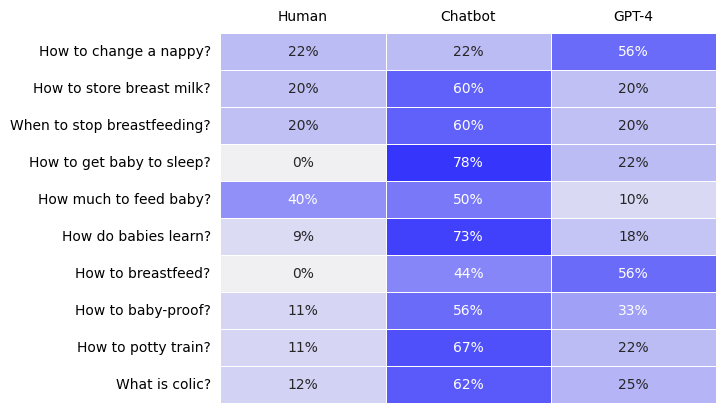

In [12]:
question_matrix = get_question_matrix(eval_df, OPTIONS, normalised=True)
plot_heatmap(question_matrix, savepath="charts/question_matrix.png", percentages=True, square=False)